In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams.update({'font.size': 12})
import seaborn as sns
import cmath
import math 
from numpy.linalg import inv
def custom_plot_single(x_lst, y_lst, label_lst, xlim, ylim, label,pltname,
                       color=['k','r','b','g','o','br'],
                       linestyle=['solid','dashed','solid','dashed','solid','dashed'],
                       markertype=[None,None,'o','^','o','^'],
                       fillstyle=['none','none','none','none','full','full'],
                       linewidth=20*[3],
                       markevery=[45,30,50,40,56,72,63,95],
                       show_legend=True,
                       plt_outside=False, y_logscale = False):
    
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    fig.patch.set_facecolor('white')
    ax1.patch.set_facecolor('white')
    for p in range(0, len(x_lst)):
        ax1.plot(x_lst[p], y_lst[p], color[p],
                 linewidth=linewidth[p],
                 linestyle=linestyle[p],
                 marker=markertype[p],
                 fillstyle=fillstyle[p],
                 markevery=markevery[p],
                 markersize=8,
                 label=label_lst[p])
    if(show_legend):
        ax1.legend(prop={'size': 20},loc='best')
    ax1.tick_params(which='minor', width=2, length=4, color='k')
    ax1.tick_params(which='major', width=2, length=8, color='k')

    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    if(show_legend):
        ax1.legend(prop={'size': 20},loc='best',shadow=True)
    if (y_logscale):
        ax1.set_yscale('log')
    ax1.set_ylim(ylim[0],ylim[1])
    ax1.set_xlim(xlim[0],xlim[1])
    ax1.set_xlabel(label[0], fontsize=25)#, fontdict=dict(weight='bold'))
    ax1.set_ylabel(label[1], fontsize=25)#, fontdict=dict(weight='bold'))
    fontsize=25
    for tick in ax1.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)

    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    if(plt_outside==False):
        plt.savefig(pltname, bbox_inches = "tight")
    return plt,pltname

import numpy.polynomial.legendre as GL
def nf(E,kT=0.025,eta=None): 
    """ The Fermi distribution """
    if eta is None:
        # Ensures that numpy does not do anything with complex numbers!
        return 1./( np.exp( E / kT ) + 1 )
    return 1./( np.exp( (E+1j*eta) / kT) + 1)

In [2]:
PrintFigures=True
PointCharge=True

### parameter definition

In [60]:
h=1.06e-34
q=1.602e-19
G_quantum=2*q**2/h #at zero temperature
print('G_quantum',G_quantum)
print('R_quantum',1/G_quantum)
gamma=2.5 #eV
acc=0.142e-9
m=17
n=0
nano=1e-9

#N=num_layers_ch
#U=avg_field_ch

def get_radius(acc,m,n):
    return acc*(np.sqrt(3.)/(2*np.pi))*np.sqrt(m**2 + m*n + n**2)


R = get_radius(acc,m,n)
print('Radius of CNT (nm):', R/nano)

Eg_min = acc*gamma/R
print('bandgap, H/(eV):', Eg_min)

Us=0.0 #V, Source potential
Ud=0.0 #V, Drain potential

N=4
print('number of layers in the channel: ', N)

q_factor = math.gcd(m, n)
Int=(m-n)/(3*q_factor)
print('q_factor',q_factor)
print('Int',Int)
if(Int.is_integer()):
    d_R = 3*q_factor
else:
    d_R = q_factor
print('d_R',d_R)
Natoms_per_UC=int(4*(m**2+m*n+n**2)/d_R)
print('number of atoms per unit cell',Natoms_per_UC)


if(n==0): #zigzag
    M =  int(Natoms_per_UC/4)
elif(m==n): #armchair
    M = int(Natoms_per_UC/2)
else:
    M = np.abs(m-n)
print('number of total modes or atoms along the ring', M)
M_red = 1
print('number of modes used to construct hamiltonian', M_red)

nring_per_unitcell = 4 #for a zigzag nanotube
print('nring_per_unitcell',nring_per_unitcell)

avg_distance_per_layer = 3*acc/nring_per_unitcell
print('avg_distance_per_layer',avg_distance_per_layer)
print('Total length', N*avg_distance_per_layer)



G_quantum 0.00048422716981132076
R_quantum 2065.1464071907617
Radius of CNT (nm): 0.665453976774103
bandgap, H/(eV): 0.5334704012453583
number of layers in the channel:  4
q_factor 17
Int 0.3333333333333333
d_R 17
number of atoms per unit cell 68
number of total modes or atoms along the ring 17
number of modes used to construct hamiltonian 1
nring_per_unitcell 4
avg_distance_per_layer 1.065e-10
Total length 4.26e-10


### #Theoretical career concentration


0.26673520062267914
2.512773854243737


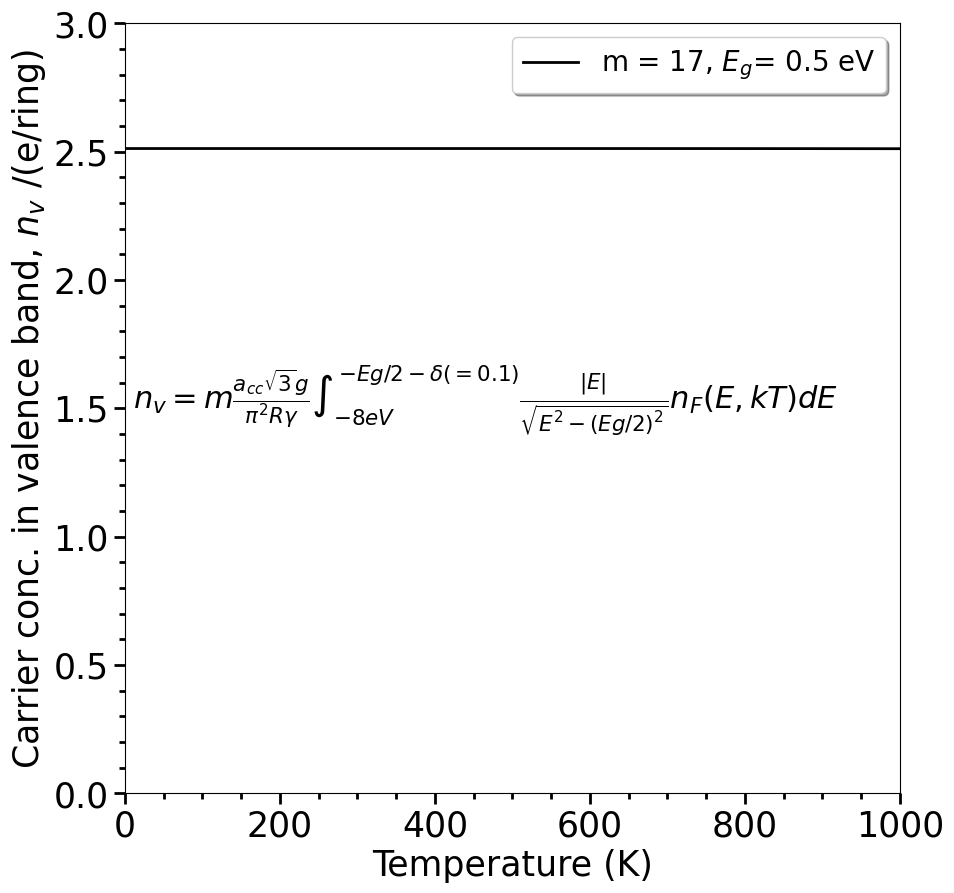

In [61]:
pts = 100
Temp_arr=np.linspace(1,1000,pts,dtype=float)
n_per_atom_th = np.zeros(pts,dtype=float)

realaxis_pts =100
Ec_th = Eg_min/2.
print(Ec_th)
E_realaxis=np.linspace(-10, -Ec_th - 1e-1,realaxis_pts,dtype=float)
deltaE=E_realaxis[1]-E_realaxis[0]


#print(E_realaxis)
mu=0
g=1 #degeneracy of subband

for t in range(0, len(Temp_arr)):
    Temp = Temp_arr[t]
    k=8.617333262e-5 #eV/K
    kT = k*Temp

    #print('Ec_th',Ec_th)
    n_mul_factor = acc*np.sqrt(3)*g/(np.pi**2 *R* gamma)
    #print('n_mul_factor',n_mul_factor)
    n_per_atom_th[t]=0.
    for e in range(0,realaxis_pts):
        nf_e = nf(E_realaxis[e]-mu, eta=0., kT=kT)
        denominator = np.sqrt(E_realaxis[e]**2-Ec_th**2)
        if(denominator == 0):
            print('DANGER',E_realaxis[e])
        n_per_atom_th[t] += n_mul_factor*(np.abs(E_realaxis[e])/denominator)*nf_e.real*deltaE
    
#print(n_per_atom_th)

if(PrintFigures):
    plt,pltname=custom_plot_single([Temp_arr], 
                       [n_per_atom_th*m],
                       [r'm = %d, $E_g$= %.1f eV'%(m,Eg_min)],
                       [0,Temp_arr[-1]],[0,3],[r'Temperature (K)',r'Carrier conc. in valence band, $n_v$ /(e/ring)'],'CarrierConcValBand_%d_0.png'%(m),
                       ['k','r','g'],
                       ['solid','dashed','solid','dashed'],
                       ['none'],
                       4*['none'],
                       [2,2,2,2],y_logscale=False)
    
    plt.text(10, 1.5, r'$n_v = m\frac{ a_{cc}\sqrt{3}g}{\pi^2R\gamma}\int_{-8 eV}^{-Eg/2 - \delta(=0.1)}\frac{|E|}{\sqrt{E^2 - (Eg/2)^2}} n_F(E,kT) dE$', fontsize=22,color='k')
    plt.savefig(pltname, bbox_inches = "tight")

print(n_per_atom_th[0]*m)

/tmp/ipykernel_10405/170817009.py:67: RuntimeWarning: overflow encountered in exp
  return 1./( np.exp( (E+1j*eta) / kT) + 1)


0.0007037713392447491


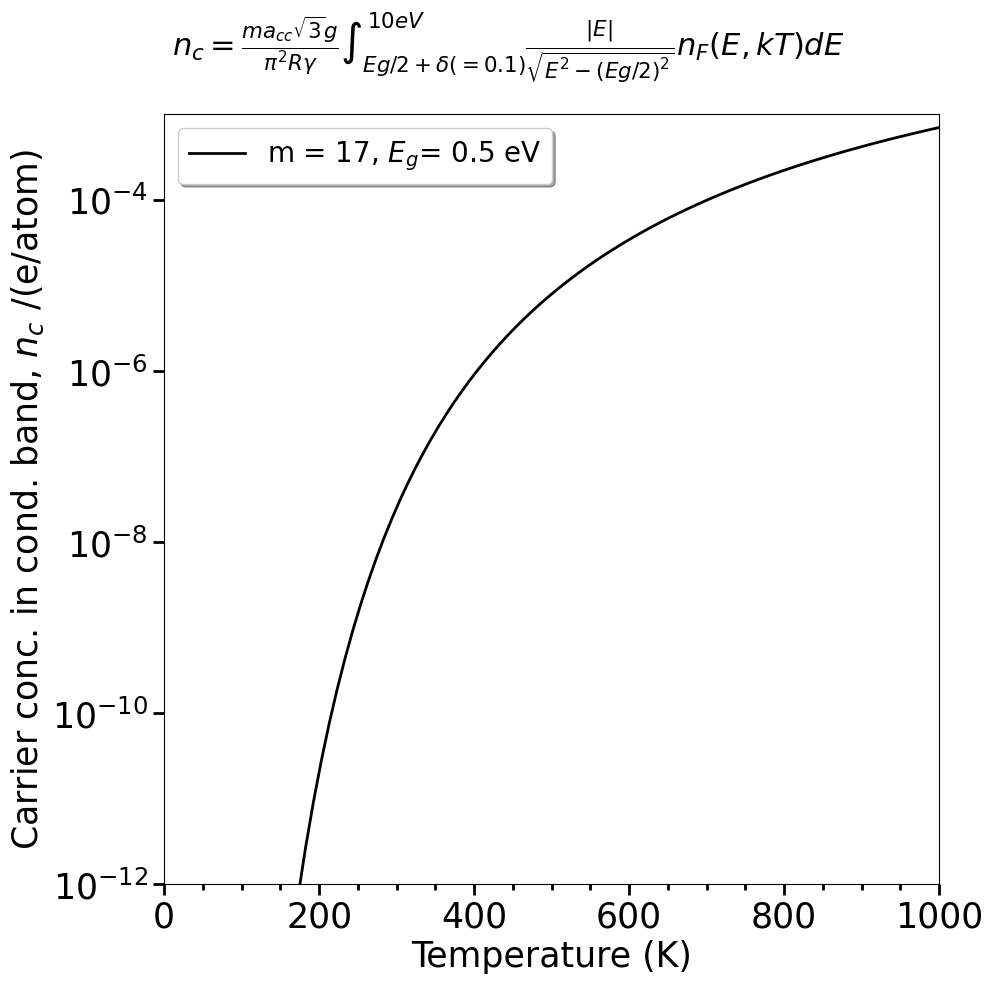

In [62]:
realaxis_pts =100
E_realaxis=np.linspace(Ec_th + 1e-1, 10,realaxis_pts,dtype=float)
deltaE=E_realaxis[1]-E_realaxis[0]

for t in range(0, len(Temp_arr)):
    Temp = Temp_arr[t]
    k=8.617333262e-5 #eV/K
    kT = k*Temp

    #print('Ec_th',Ec_th)
    n_mul_factor = acc*np.sqrt(3)*g/(np.pi**2 *R* gamma)
    #print('n_mul_factor',n_mul_factor)
    n_per_atom_th[t]=0.
    for e in range(0,realaxis_pts):
        nf_e = nf(E_realaxis[e]-mu, eta=0., kT=kT)
        denominator = np.sqrt(E_realaxis[e]**2-Ec_th**2)
        if(denominator == 0):
            print('DANGER',E_realaxis[e])
        n_per_atom_th[t] += n_mul_factor*(np.abs(E_realaxis[e])/denominator)*nf_e.real*deltaE
    
#print(n_per_atom_th)

if(PrintFigures):
    plt,pltname=custom_plot_single([Temp_arr], 
                       [n_per_atom_th*m],
                       [r'm = %d, $E_g$= %.1f eV'%(m,Eg_min)],
                       [0,Temp_arr[-1]],[1e-12,1e-3],[r'Temperature (K)',r'Carrier conc. in cond. band, $n_c$ /(e/atom)'],'CarrierConcCondBand_%d_0.png'%(m),
                       ['k','r','g'],
                       ['solid','dashed','solid','dashed'],
                       ['none'],
                       4*['none'],
                       [2,2,2,2],y_logscale=True)
    
    plt.text(10, 5e-3, r'$n_c = \frac{m a_{cc}\sqrt{3}g}{\pi^2R\gamma}\int_{Eg/2+\delta(=0.1)}^{10 eV}\frac{|E|}{\sqrt{E^2 - (Eg/2)^2}} n_F(E,kT) dE$', fontsize=22,color='k')
    plt.savefig(pltname, bbox_inches = "tight")

print(n_per_atom_th[-1]*m)